# Spectral simulations with gammapy

## Studying systematic effects on spectral parameters

### Objective

**Quantify the systematic errors on spectral parameters caused by a possible absolute energy scale bias using simulations.**

### Steps

* Create a fake observation of the Crab using CTA alpha configuration and build a 1D spectrum dataset for this observation
* Fake multiple times a log-parabola source spectrum with ON-OFF statistic and fit it and to measure the statistcal uncertainty expected
* Build a custom spectral model to take into account possible systematic bias in absolute energy scale
* Perform simulations of the observation taking into account the systematic effect of the energy scale bias on the fitted spectral parameters. Measure the systematic uncertainty introduced.
* Perform the same thing for an uncertainty of the alpha parameter 

In [1]:
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from gammapy.data import Observation, observatory_locations
from gammapy.irf import load_cta_irfs
from gammapy.maps import MapAxis, Map, RegionGeom
from gammapy.datasets import SpectrumDataset, Datasets, SpectrumDatasetOnOff
from gammapy.makers import SpectrumDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, LogParabolaSpectralModel
import matplotlib.pyplot as plt 

In [7]:
irfs = load_cta_irfs("/home/savchenk/diffusesource/gammapy-data/1.0/cta-caldb/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz")

#### Define pointing positions

Here we use a wobble position around the Crab.

In [9]:
target = SkyCoord(83.6333, 22.0133, unit="deg", frame="icrs")

pointing = target.spherical_offsets_by(1*u.deg, 1*u.deg) 
print(pointing)

<SkyCoord (ICRS): (ra, dec) in deg
    (84.7195833, 23.00974691)>


We assume a 3 hours long observation (for simplicity we don't create a list of shorter runs).

In [10]:
livetime = 3 * u.h

obs = Observation.create(pointing=pointing, irfs=irfs, livetime=livetime)

In [11]:
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.13
	duration          : 10800.00 s
	pointing (icrs)   : 84.7 deg, 23.0 deg

	deadtime fraction : 0.0%



### Defining the reduced dataset geometry

We prepare the 1D spectra geometry. We need to provide the binning in reco and true energy, for the counts, counts_off and the IRFs.

We take a region of 0.1 degree around the Crab nebula

In [13]:
energy = MapAxis.from_energy_bounds(0.05, 100, 5, unit='TeV', per_decade=True)
energy_true = MapAxis.from_energy_bounds(0.05, 100, 5, unit='TeV', per_decade=True, name="energy_true")

geom = RegionGeom.create("icrs;circle(83.633, 22.014, 0.1)", axes=[energy])

In [14]:
reference_dataset = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_true, name="crab_dataset"
)

#### Instantiate the data reduction Makers
- SpectrumDatasetMaker projects the events and IRF in the correct geometry. Here we require that PSF leakage is to be corrected.
- We don't create a background maker since there is no counts information to rely on here. We are just interested in getting the expected background in the ON region.
- The SafeMaskMaker will create a boolean mask stored on the Dataset to deal with the safe energy range. Here we impose that the energy bias be less than 10%. 


In [17]:
maker = SpectrumDatasetMaker(selection=["exposure", "background", "edisp"])
safe_mask_maker = SafeMaskMaker(methods=["edisp-bias"], bias_percent=10)

### Data reduction 
Now we can perform the data reduction to create the reference `Dataset`. 

In [18]:
# reference_dataset = XXX
reference_dataset = maker.run(reference_dataset, obs)

As expected the reference dataset contains only the number of expected background counts but no signal.

/home/savchenk/miniconda3/envs/__gammapy@1.0/lib/python3.11/site-packages/gammapy/maps/region/ndmap.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


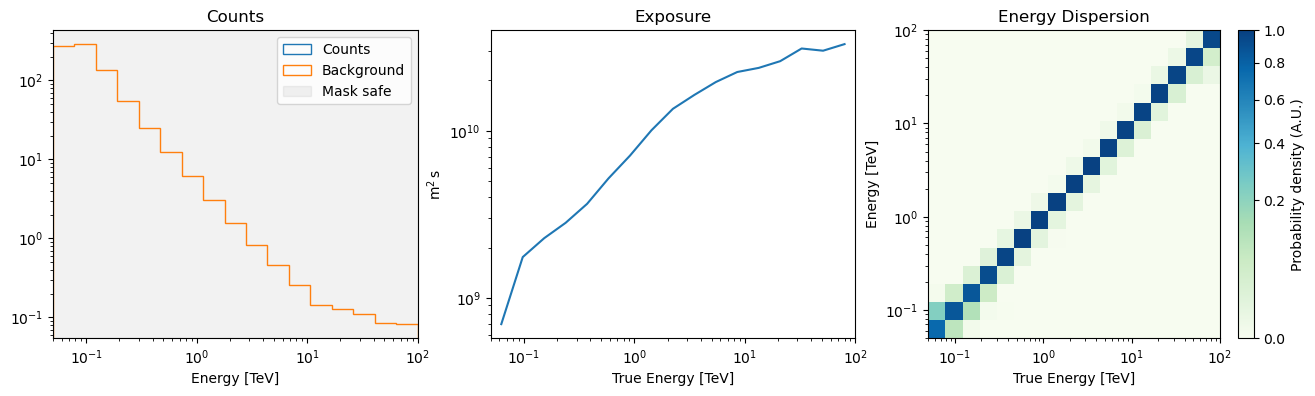

In [19]:
reference_dataset.peek()

## Simulate datasets

### Model definition

Source models in gammapy are `SkyModel`. They are usually the combination of a `SpectralModel`, a `SpatialModel` and possibly a `TemporalModel`.

Here we only need a `SpectralModel`. It is the only mandatory component.

In [21]:
spectral_model = LogParabolaSpectralModel(
        alpha=2.5,
        beta=0.25, 
        amplitude="3.8e-11 cm-2s-1TeV-1",
        reference="1 TeV",
    )

model = SkyModel(spectral_model=spectral_model, name="crab-model")

In [22]:
reference_dataset.models = [model]

### Create ON-OFF datasets

Since background maker was applied the datasets are regular datasets: i.e. they contain a background model but no acceptance ON and OFF nor OFF counts. 

We have therefore to convert them to the proper format adding the required information. The OFF counts will be simulted later.

#### Create acceptance vectors

we assume energy independent alpha_onoff=1/10: 

In [24]:
acceptance = 0.1
acceptance_off = 0.9

#### Fake counts

Here we create the ON-OFF datasets and fake their content.

We perform a large number of simulations to explore the disctribution of fitted parameters.

In [96]:
# %%time
n_sim = 1000
# n_sim = 10
simulated_datasets = []

for i in range(n_sim):
    dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(dataset=reference_dataset, acceptance=acceptance, acceptance_off=acceptance_off, name=f"dataset_{i}" )
    dataset_on_off.fake(Map.from_geom(geom, unit="deg2"))
    simulated_datasets.append(dataset_on_off)

### Perform the fit

Here we fit a log parabola on the data and explore the distribution of parameters

In [97]:
# %%time

results = []
fit = Fit()
for dataset in simulated_datasets:
    p = fit.run(dataset).parameters
    d = dict(zip(p.names, p.value))
    d.pop('reference')
    results.append(d)


In [78]:
import pandas as pd

We convert the list of dictionnaries into an astropy `Table`.

In [146]:
fitted_params = pd.DataFrame(results)
fitted_params

fitted_params['amplitude'] *= 1e11

We compute the statistical errors from the distribution of the MC realizations.

In [143]:
mean = fitted_params.mean()
uncertainty = fitted_params.std()

In [144]:
for name in ['amplitude', 'alpha', 'beta']:
    print(f"{name} :\t {mean[name]:.2e} -+ {uncertainty[name]:.2e}")

amplitude :	 3.84e-11 -+ 4.64e-13
alpha :	 2.51e+00 -+ 1.28e-02
beta :	 2.54e-01 -+ 5.90e-03


#### Looking at the simulation results

We can use the corner package to represent the fitted parameters correlations.

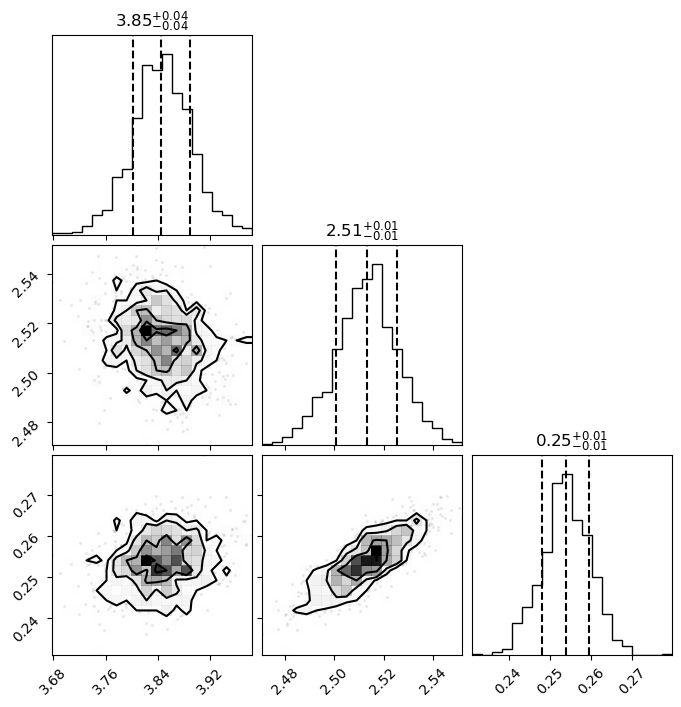

In [147]:
import corner

# fitted_params['amplitude'] *= 1e11

figure = corner.corner(fitted_params,quantiles=[0.16, 0.5, 0.84],
              show_titles=True, title_kwargs={"fontsize": 12})

## Exploring systematic effects: energy scale bias

#### Creating a biased log-parabola model

A systematic bias in the energy reconstruction that is not accounted for by the energy dispersion could have a significant impact of the fitted spectral parameters of the Crab nebula.

We propose to explore this idea in the code below.

We first use the possibility offered by gammapy to create a custom model to add a log parabola model with a systematic constant energy bias. This bias will come in addition to the one stored in the `edisp` and quantified by the shower simulations.

In [148]:
from gammapy.modeling import Parameter
from gammapy.modeling.models import SpectralModel, LogParabolaSpectralModel

class BiasedLogParabolaSpectralModel(SpectralModel):
    tag = "BiasedLogParabolaSpectralModel"
    amplitude = Parameter("amplitude", "1e-12 cm-2 s-1 TeV-1", min=0, is_norm=True)
    alpha = Parameter("alpha", 2.5, min=0)
    beta = Parameter("beta", 0.5)
    reference = Parameter("reference", "1 TeV", frozen=True)
    bias = Parameter("bias", 1, min=0)
        
    @staticmethod
    def evaluate(energy, amplitude, alpha, beta, reference, bias):
        energy = bias.value * energy
        logpwl = LogParabolaSpectralModel.evaluate(
            energy=energy,
            alpha=alpha,
            beta=beta,
            amplitude=amplitude,
            reference=reference,
        )
        return logpwl

We can look at the resulting spectra. Obviously the impact on the amplitude is very significant.

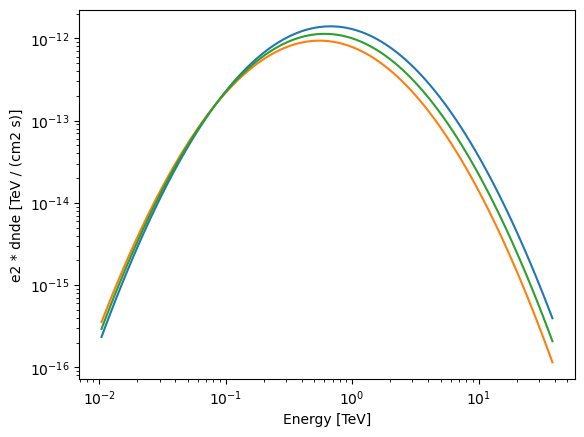

In [106]:
biased_spectral_model = BiasedLogParabolaSpectralModel()
biased_spectral_model.bias.value=0.9
ax = biased_spectral_model.plot([0.01,40]*u.TeV, energy_power=2)
biased_spectral_model.bias.value=1.1
biased_spectral_model.plot([0.01,40]*u.TeV, energy_power=2, ax=ax)
biased_spectral_model.bias.value=1.0
biased_spectral_model.plot([0.01,40]*u.TeV, energy_power=2, ax=ax);

In [107]:
biased_spectral_model = BiasedLogParabolaSpectralModel()

biased_spectral_model.alpha.value = spectral_model.alpha.value
biased_spectral_model.beta.value = spectral_model.beta.value
biased_spectral_model.amplitude.value = spectral_model.amplitude.value

In [149]:
biased_model = SkyModel(spectral_model=biased_spectral_model, name="biased_crab")

#### Fake counts taking bias into account

Here we use the biased model and randomize the bias values. We then create the ON-OFF datasets and fake their content.

We assume a typical uncertainty on the energy scale of 3 percent.

In [195]:
# %%time
simulated_biased_datasets = []
from scipy.stats import norm

for i in range(n_sim):
    biased_model.spectral_model.bias.value = norm.rvs(1, 0.03)
    print("setting bias", biased_model.spectral_model.bias.value)
    reference_dataset.models = [biased_model]

    dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
        dataset=reference_dataset, 
        acceptance=acceptance, 
        acceptance_off=acceptance_off, 
        name=f"dataset_{i}"
    )
    dataset_on_off.fake(Map.from_geom(geom, unit="deg2"))

    dataset_on_off.models = [model]
    simulated_biased_datasets.append(dataset_on_off)

setting bias 1.0184614003480825
setting bias 0.9895895339150649
setting bias 0.955120106414554
setting bias 1.0281171295801963
setting bias 0.9861126553307928
setting bias 0.9672165976109036
setting bias 1.0036520994013716
setting bias 1.0075478056031524
setting bias 1.0078794920432583
setting bias 0.9912119039550622
setting bias 0.9911295302674914
setting bias 1.0214484185748394
setting bias 0.9614978759365072
setting bias 0.9862457325305761
setting bias 0.9929983020815445
setting bias 0.9998868240508652
setting bias 0.9549693132232451
setting bias 1.0086990050576097
setting bias 1.0087774650518495
setting bias 1.0140120362477838
setting bias 1.0383616356614878
setting bias 0.9885590218544456
setting bias 0.9623268421665119
setting bias 1.0000848638647344
setting bias 0.9894558369553015
setting bias 0.9797306749870931
setting bias 0.9935298819236265
setting bias 1.0194214493743148
setting bias 1.0603608887977356
setting bias 0.9878680355850972
setting bias 1.015314657638757
setting bi

### Perform the fit

Here we fit a log parabola without a bias on the data and explore the distribution of parameters

In [232]:
# %%time

results_biased = []
fit = Fit()
for dataset in simulated_biased_datasets:
    p = fit.run(dataset).parameters
    d = dict(zip(p.names, p.value))
    d.pop('reference')
    d['amplitude'] *= 1e11
    results_biased.append(d)
    print(d)

{'amplitude': 3.2938824506497486, 'alpha': 2.5912589416908327, 'beta': 0.27461853725740853}
{'amplitude': 3.2921943904275808, 'alpha': 2.5727321136138728, 'beta': 0.26167255982831267}
{'amplitude': 3.364222619485321, 'alpha': 2.5502732002904764, 'beta': 0.2604698462610066}
{'amplitude': 3.289604979192297, 'alpha': 2.5633876667047253, 'beta': 0.2606012601857911}
{'amplitude': 3.2987751073123497, 'alpha': 2.5684643345119857, 'beta': 0.2625972104334187}
{'amplitude': 3.315624584696998, 'alpha': 2.5654982394415744, 'beta': 0.264592774821846}
{'amplitude': 3.2688528245260824, 'alpha': 2.6012632386346763, 'beta': 0.27314305160715663}
{'amplitude': 3.3266792424340412, 'alpha': 2.5982365234375684, 'beta': 0.2830549411260668}
{'amplitude': 3.2884844351735683, 'alpha': 2.5701533149685782, 'beta': 0.26452680079945834}
{'amplitude': 3.306966537006526, 'alpha': 2.575363720272449, 'beta': 0.26810728495078195}
{'amplitude': 3.349901164135063, 'alpha': 2.554778767276834, 'beta': 0.2579195641392359}
{'

In [233]:
fitted_params_with_energy_bias = Table(results_biased).to_pandas()
fitted_params_with_energy_bias.std(), fitted_params.std()

(amplitude    0.043498
 alpha        0.014055
 beta         0.006325
 dtype: float64,
 amplitude    0.046359
 alpha        0.012757
 beta         0.005897
 dtype: float64)

In [234]:
total_mean = fitted_params_with_energy_bias.mean()
total_uncertainty = fitted_params_with_energy_bias.std()

In [235]:
for name in ['amplitude', 'alpha', 'beta']:
    print(f"{name} :\t {total_mean[name]:.2e} -+ {total_uncertainty[name]:.2e}")

amplitude :	 3.30e+00 -+ 4.35e-02
alpha :	 2.57e+00 -+ 1.41e-02
beta :	 2.66e-01 -+ 6.33e-03


To separate statistics from systematics we assume the toatl uncertainty is the quadratic sum of statistic and systematic errors.

In [236]:
systematic_uncertainty = np.sqrt(total_uncertainty**2 - uncertainty**2)
systematic_uncertainty

amplitude    0.043498
alpha        0.005900
beta         0.002286
dtype: float64

In [237]:
for name in ['amplitude', 'alpha', 'beta']:
    print(f"{name} :\t {total_mean[name]:.2e} -+\t"
          f" {uncertainty[name]:.2e} (stat) -+\t"
          f" {systematic_uncertainty[name]:.2e} (sys)")

amplitude :	 3.30e+00 -+	 4.64e-13 (stat) -+	 4.35e-02 (sys)
alpha :	 2.57e+00 -+	 1.28e-02 (stat) -+	 5.90e-03 (sys)
beta :	 2.66e-01 -+	 5.90e-03 (stat) -+	 2.29e-03 (sys)


## Exploring systematic effects: uncertainty of alpha_onoff (ratio of ON/OFF acceptance)

#### Simulated data with an additional bias of alpha_onoff

A systematic bias in the estimation of alpha_onoff can also occur. 
In the following we will assume that the ON acceptance is uncertain by a factor of 5%.


In [238]:
# %%time
simulated_biased_datasets = []

for i in range(n_sim):
    acceptance_random = norm.rvs(acceptance, 0.05)
    # print("acceptance", acceptance_random)
    reference_dataset.models = [model]
    dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(dataset=reference_dataset, acceptance=acceptance_random, acceptance_off=acceptance_off, name=f"dataset_{i}" )
    dataset_on_off.fake(Map.from_geom(geom, unit="deg2"))
    dataset_on_off.acceptance = Map.from_geom(dataset._geom, data=acceptance)
    simulated_biased_datasets.append(dataset_on_off)

In [239]:
# %%time

results_biased = []
fit = Fit()
for dataset in simulated_biased_datasets:
    p = fit.run(dataset).parameters
    d = dict(zip(p.names, p.value))
    d.pop('reference')
    d['amplitude'] *= 1e11
    results_biased.append(d)
    print(d)

{'amplitude': 3.2866205124659587, 'alpha': 2.572192807328799, 'beta': 0.2663822030592793}
{'amplitude': 3.2380717753973465, 'alpha': 2.5865924514443392, 'beta': 0.2738363082245084}
{'amplitude': 3.311373181949286, 'alpha': 2.566253426952526, 'beta': 0.2590757350485873}
{'amplitude': 3.34054518779915, 'alpha': 2.5784727849770537, 'beta': 0.27234086021811443}
{'amplitude': 3.278139182108231, 'alpha': 2.547502822685823, 'beta': 0.2576643493585592}
{'amplitude': 3.3849341587402155, 'alpha': 2.558021882322813, 'beta': 0.26806612744144465}
{'amplitude': 3.3315363101821998, 'alpha': 2.5452020614714077, 'beta': 0.25619982310465167}
{'amplitude': 3.3021577180437403, 'alpha': 2.548570772775026, 'beta': 0.26023739985412153}
{'amplitude': 3.2585241719396763, 'alpha': 2.5637302523894427, 'beta': 0.25658813012553877}
{'amplitude': 3.235172158099772, 'alpha': 2.564299161387412, 'beta': 0.25480550577967737}
{'amplitude': 3.314075315126516, 'alpha': 2.5689843245368595, 'beta': 0.26821638049346774}
{'am

In [240]:
fitted_params_with_alpha_bias = Table(results_biased).to_pandas()
total_mean = fitted_params_with_alpha_bias.mean()
total_uncertainty = fitted_params_with_alpha_bias.std()

In [241]:
for name in ['amplitude', 'alpha', 'beta']:
    print(f"{name} :\t {total_mean[name]:.2e} -+ {total_uncertainty[name]:.2e}")

amplitude :	 3.30e+00 -+ 4.45e-02
alpha :	 2.57e+00 -+ 1.43e-02
beta :	 2.63e-01 -+ 6.66e-03


In [229]:
systematic_uncertainty = np.sqrt(total_uncertainty**2 - uncertainty**2)

In [242]:
for name in ['amplitude', 'alpha', 'beta']:
    print(f"{name} :\t {total_mean[name]:.2e} -+\t"
          f" {uncertainty[name]:.2e} (stat) -+\t"
          f" {systematic_uncertainty[name]:.2e} (sys)")

amplitude :	 3.30e+00 -+	 4.64e-13 (stat) -+	 4.35e-02 (sys)
alpha :	 2.57e+00 -+	 1.28e-02 (stat) -+	 5.90e-03 (sys)
beta :	 2.63e-01 -+	 5.90e-03 (stat) -+	 2.29e-03 (sys)


## Going further

- Plot the average fitted spectrum with the butterflies of errors
- Combine the two effects
- Introduce an uncertainty on the effective area by adding an uncertainty on the spectral index and amplitude of the simulated source (e.g. by multplying it by a PowerLawNormSpectralModel)